# NEW curve_fit fitting with TOI-4468 TESS Data

In [1]:
#Imports:
#Standard:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

#Keplerspline:
from keplersplinev2 import *
import lightkurve as lk
from astropy.io import fits
import sys

#Batman
import batman


In [3]:
np.set_printoptions(threshold=sys.maxsize)
flux_clean = []
time_clean = []

fits_filename = 'tess2021204101404-s0041-0000000441763252-0212-s_lc.fits'
hdul = fits.open(fits_filename)
hdul.info()
primary_hdu = hdul[1]
# Get the data (e.g., image or table data)
#data = primary_hdu.data
# Get the header information
header = primary_hdu.header
# Print the header
#print(repr(header))
# Access the table data in the second HDU
table_data = hdul[1].data

# Print the names of the columns
#print(table_data.columns.names)
# Access a specific column
time = table_data['TIME']
flux = table_data['PDCSAP_FLUX']
#print(flux)
for i in range(len(flux)):
    if not np.isnan(flux[i]):
        flux_clean.append(flux[i])
        time_clean.append(time[i])
time=np.array(time_clean)
flux=np.array(flux_clean)

Filename: tess2021204101404-s0041-0000000441763252-0212-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   19149R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


In [4]:
#Calculating the Keplerspline
#median = np.median(flux)
#flux = flux/median
s = keplersplinev2(time, flux, bkspace = 2)
#fig, ax = plt.subplots(figsize=(16, 8))
#plt.plot(time, flux,'.')
#plt.plot(time_clean, s,'o')

In [5]:
#Essentially performing lightkurve-style Light Curve 
#normalization
flux_norm = flux/s
#plotting = plt.plot(time, flux_norm,'.')
#print(plotting)

In [6]:
#Splitting the Time and Flux Array:
timesubarrays = np.array_split(time,9)
fluxsubarrays = np.array_split(flux_norm,9)


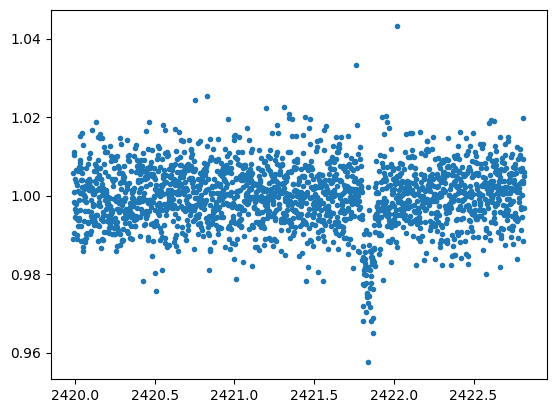

In [8]:
plt.plot(timesubarrays[0],fluxsubarrays[0],'.')

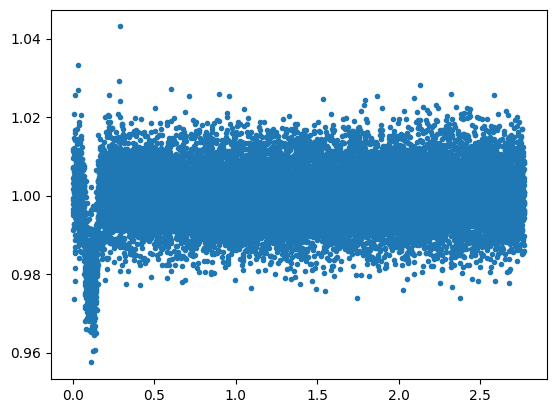

In [9]:
#Phase Folding:
period = 2.770860
t0 = 0#2430.16
phase = (time % period)
plt.plot(phase,flux_norm,'.')

In [10]:
t0values = []

In [11]:
#Initializing Arrays for t and flux:
t = timesubarrays[0]
flux = fluxsubarrays[0]

In [12]:
initial_t0_guess=2421.8
t0=2421.8#2438.4663346073316
print(initial_t0_guess)

2421.8


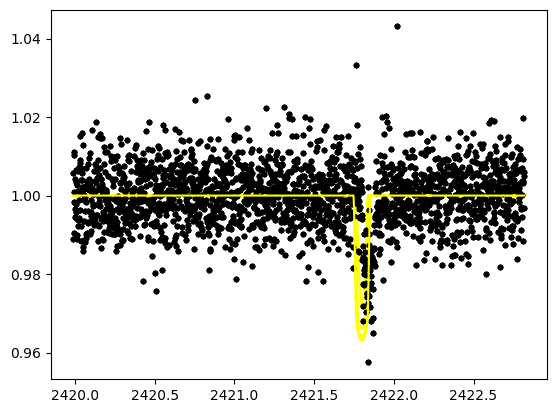

In [13]:
#NOTE: ratio of planet radius to stellar radius
#Defining the Transit Model:
def transit_model_t0(t, t0, per=2.770860, rp=0.18,#(12.247/109/.79),\
a=9.84875656,inc=90.,ecc=0,w=0,u1=0.5,u2=0.1,u3=0.1,u4=-0.1):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                         #time of inferior conjunction
    params.per = per                 #orbital period(days)
    params.rp = rp          #planet radius (in units of stellar radii)
    params.a = a                 #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = ecc                       #eccentricity
    params.w = w                         #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [u1, u2, u3, u4]      #limb darkening coefficients [u1, u2, u3, u4]


    m = batman.TransitModel(params, t)    #initializes model
    
    return m.light_curve(params)
    
inclination = np.linspace(85, 90, 5)
    
for i in inclination:
#    params.inc = i                           #updates planet radius
    new_flux = transit_model_t0(t, t0=t0, inc=i)        #recalculates light curve
    plt.plot(t, flux, '.', color = 'black')
    plt.plot(t, new_flux,'yellow')

Best-fit t0 value from differential evolution: 2421.8415309359343


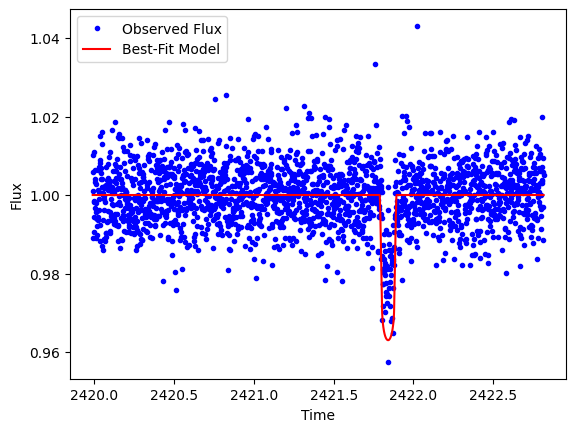

In [15]:
# Define chi-square function
def chi_square(params, t, y_obs, sigma):
    t0 = params[0]  # In this case, we're optimizing over t0
    y_model = transit_model_t0(t, t0)  # Generate model light curve with current t0
    return np.sum(((y_obs - y_model) / sigma)**2)  # Chi-square calculation

# Set your bounds for the parameter t0 (inferior conjunction time)
bounds = [(2421.6, 2422.4)]  # Adjust bounds as needed

# Perform differential evolution to find the best t0
result = differential_evolution(chi_square, bounds, args=(t, flux, 0.001))

# Extract the best-fitting t0 value
best_t0 = result.x[0]
print("Best-fit t0 value from differential evolution:", best_t0)

# Plot the results
plt.plot(t, flux, 'b.', label="Observed Flux")
plt.plot(t, transit_model_t0(t, best_t0), 'r-', label="Best-Fit Model")
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [ ]:
# Define the objective function for differential_evolution
#def chi_square(params, x, y_obs, sigma):
#    transit_model = transit_model_t0(t, params)
#    return np.sum(((y_obs - transit_model) / sigma)**2)
#bounds = [2421.7, 2421.9]
# Use differential_evolution to find initial guess
#result = differential_evolution(chi_square, bounds, args=(t, flux))

In [ ]:
# Perform the initial fit

params, params_covariance = curve_fit(transit_model_t0, t, flux, p0 = [initial_t0_guess],bounds = [2421.7,2421.9],ftol=1e-10, xtol=1e-10, maxfev=1000000)
t0 = params
print("Best-fit t0 value:", params[0])
t0values.append(params[0])


In [ ]:
new_flux=transit_model_t0(t,t0=2421.661728287978)
plt.plot(t,flux,'.', color = 'black')
plt.plot(t,new_flux)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import batman

# Define the transit model function
def transit_model_t0(t, t0, per=2.770860, rp=0.1, a=9.84875656, inc=90., ecc=0, w=0, u1=0.5, u2=0.1, u3=0.1, u4=-0.1):
    params = batman.TransitParams()
    params.t0 = t0
    params.per = per
    params.rp = rp
    params.a = a
    params.inc = inc
    params.ecc = ecc
    params.w = w
    params.limb_dark = "nonlinear"
    params.u = [u1, u2, u3, u4]

    m = batman.TransitModel(params, t)
    return m.light_curve(params)

# Example time array (should include t0)
t = np.linspace(2420, 2425, 100)  # Adjust to ensure t0 is included
flux = transit_model_t0(t, t0=2422.0)  # Generate the model light curve

# Plot the model
plt.plot(t, flux, label='Transit Model', color='red')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Transit Light Curve')
plt.legend()
plt.show()

In [ ]:
#Plotting
#plt.figure(figsize=(30, 6))

#plt.plot(phase, y, 'o', label='Data', color='red')
#plt.plot(phase, y_fit, '.', markersize = 20, label='Fitted sine curve', color='blue', linewidth=2)

#t_fit = np.linspace(0, 1, 100)
#y_line = fit_function(t_fit, amp_fit, phase_fit, vert_fit)
#plt.plot(t_fit, y_line, label='Fitted sine curve', color='blue', linewidth=.5)

#plt.legend()
#plt.show()

In [ ]:
#import pandas as pd
#lst1 = phase
#lst2 = y
#list = pd.DataFrame(
#    {'phase': lst1,
#     'y': lst2,
#    })
#list_sort = list.sort_values(by='phase', ascending=True)
#type(list_sort)

#phase = list_sort['phase'].astype(int).tolist()
#y = list_sort['y'].astype(int).tolist()
#phase = np.array(phase)

In [ ]:
# Error and accuracy calculator
#error = y_fit - y
#chi_square = np.sum((error)**2 / y)